In [1]:
# -------------------------------
# 🌞 Step 1: Setup & Imports
# -------------------------------
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

# Create folder for models
os.makedirs("models", exist_ok=True)

# Location & API keys
LAT, LON = 12.97, 77.59  # Bengaluru
OWM_API_KEY = "315f293daca93eaf2847d326cec66326"  # your valid API key

# NASA POWER API date range
START_DATE = "20190101"
END_DATE   = "20251031"

print("✅ Setup complete! Folder 'models' created.")


✅ Setup complete! Folder 'models' created.


In [2]:
# -------------------------------
# ☀️ Step 2: Fetch NASA POWER Data
# -------------------------------
nasa_url = (
    f"https://power.larc.nasa.gov/api/temporal/daily/point?"
    f"parameters=ALLSKY_SFC_SW_DWN,WS10M,T2M,RH2M,PRECTOTCORR,ALLSKY_KT"
    f"&community=RE&longitude={LON}&latitude={LAT}"
    f"&start={START_DATE}&end={END_DATE}&format=JSON"
)

response = requests.get(nasa_url).json()
records = response["properties"]["parameter"]

nasa_df = pd.DataFrame({
    "solar_radiation": list(records["ALLSKY_SFC_SW_DWN"].values()),
    "wind_speed": list(records["WS10M"].values()),
    "temperature": list(records["T2M"].values()),
    "humidity": list(records.get("RH2M", {}).values()) if "RH2M" in records else [],
    "rainfall": list(records.get("PRECTOTCORR", {}).values()) if "PRECTOTCORR" in records else [],
    "clearsky_index": list(records.get("ALLSKY_KT", {}).values()) if "ALLSKY_KT" in records else []
})

nasa_df["date"] = pd.to_datetime(list(records["T2M"].keys()))
nasa_df = nasa_df.dropna().drop_duplicates(subset=["date"]).sort_values("date")

print("✅ NASA data fetched successfully:", nasa_df.shape)
nasa_df.head()


✅ NASA data fetched successfully: (2496, 7)


,solar_radiation,wind_speed,temperature,humidity,rainfall,clearsky_index,date
0,6.0528,3.79,19.39,47.59,0.0,0.73,2019-01-01
1,6.0701,4.26,19.22,49.99,0.0,0.73,2019-01-02
2,6.0120,4.09,19.63,49.04,0.0,0.72,2019-01-03
3,6.0348,4.66,19.57,51.83,0.0,0.73,2019-01-04
4,6.1406,3.56,19.89,52.66,0.0,0.74,2019-01-05


In [3]:
# -------------------------------
# 🌦️ Step 3: Fetch OWM Current Weather
# -------------------------------
owm_url = f"https://api.openweathermap.org/data/2.5/weather?lat={LAT}&lon={LON}&appid={OWM_API_KEY}&units=metric"
owm_response = requests.get(owm_url).json()

owm_data = {
    "date": datetime.now(),
    "humidity": owm_response["main"]["humidity"],
    "pressure": owm_response["main"]["pressure"],
    "clouds": owm_response["clouds"]["all"]
}
owm_df = pd.DataFrame([owm_data])
print("✅ OWM weather fetched successfully.")
owm_df.head()


✅ OWM weather fetched successfully.


,date,humidity,pressure,clouds
0,2025-11-08 15:22:08.464564,52,1011,40


In [4]:
# -------------------------------
# 🧩 Step 4: Combine NASA + OWM + Time Features
# -------------------------------
final_df = nasa_df.copy()

# Add OWM weather details as contextual columns
final_df["pressure"] = owm_df["pressure"].iloc[0]
final_df["clouds"] = owm_df["clouds"].iloc[0]

# Add temporal features
final_df["month"] = final_df["date"].dt.month
final_df["dayofyear"] = final_df["date"].dt.dayofyear
final_df["doy_sin"] = np.sin(2 * np.pi * final_df["dayofyear"] / 365.25)
final_df["doy_cos"] = np.cos(2 * np.pi * final_df["dayofyear"] / 365.25)

print("✅ Combined dataset shape:", final_df.shape)
final_df.head()


✅ Combined dataset shape: (2496, 13)


,solar_radiation,wind_speed,temperature,humidity,rainfall,clearsky_index,date,pressure,clouds,month,dayofyear,doy_sin,doy_cos
0,6.0528,3.79,19.39,47.59,0.0,0.73,2019-01-01,1011,40,1,1,0.017202,0.999852
1,6.0701,4.26,19.22,49.99,0.0,0.73,2019-01-02,1011,40,1,2,0.034398,0.999408
2,6.0120,4.09,19.63,49.04,0.0,0.72,2019-01-03,1011,40,1,3,0.051584,0.998669
3,6.0348,4.66,19.57,51.83,0.0,0.73,2019-01-04,1011,40,1,4,0.068755,0.997634
4,6.1406,3.56,19.89,52.66,0.0,0.74,2019-01-05,1011,40,1,5,0.085906,0.996303


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27540\116657481.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27540\116657481.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")


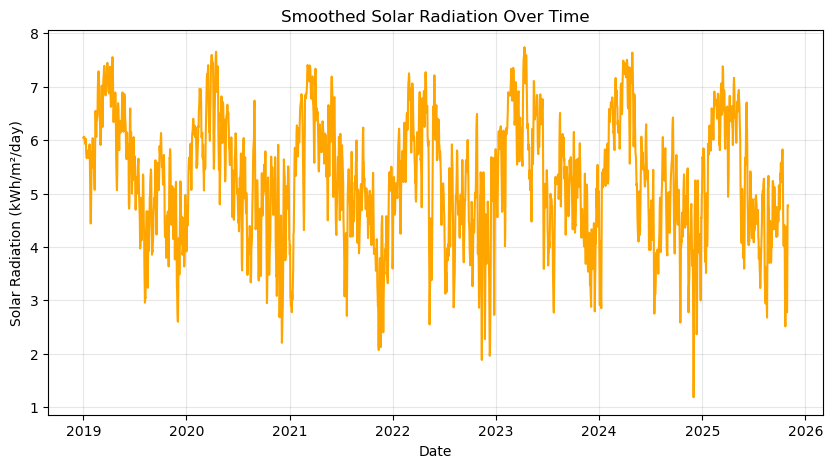

✅ Target smoothed successfully.


In [5]:
# -------------------------------
# 🌞 Step 5: Smooth Solar Radiation
# -------------------------------
final_df["solar_radiation"] = (
    final_df["solar_radiation"]
    .rolling(window=3, center=True)
    .mean()
    .fillna(method="bfill")
    .fillna(method="ffill")
)

plt.figure(figsize=(10,5))
plt.plot(final_df["date"], final_df["solar_radiation"], color="orange")
plt.title("Smoothed Solar Radiation Over Time")
plt.xlabel("Date")
plt.ylabel("Solar Radiation (kWh/m²/day)")
plt.grid(alpha=0.3)
plt.show()

print("✅ Target smoothed successfully.")


In [6]:
# -------------------------------
# 🧩 Step 6–7: Proper Temporal Scaling + Sequential Split
# -------------------------------
from sklearn.preprocessing import MinMaxScaler
import joblib

features = [
    "solar_radiation", "wind_speed", "temperature",
    "humidity", "rainfall", "clearsky_index",
    "pressure", "clouds",
    "month", "dayofyear", "doy_sin", "doy_cos"
]

# Fill missing columns safely
for col in features:
    if col not in final_df.columns:
        final_df[col] = 0

# Scale entire dataset once
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(final_df[features])

# Create sequences first, then split
def create_sequences(data, lookback=90):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i, 0])  # solar_radiation
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(scaled_all, lookback=90)

# Split AFTER sequences — ensures temporal continuity
split_index = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]

# Save scaler and feature order
joblib.dump({"scaler": scaler, "features": features}, "models/scaler_final.pkl")

print("✅ Fixed temporal scaling and sequential split complete.")
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


✅ Fixed temporal scaling and sequential split complete.
Train shape: (1924, 90, 12)  Test shape: (482, 90, 12)


In [7]:
import joblib
s = joblib.load("models/scaler_final.pkl")
print(s.keys())


dict_keys(['scaler', 'features'])


In [8]:
# -------------------------------
# 🧩 Step 8: Build Residual LSTM Model
# -------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Add
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Dropout(0.3)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0003), loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 90, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 90, 256)             │         144,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,785 (901.50 KB)

 Trainable params: 230,785 (901.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# -------------------------------
# 🧩 Step 9: Optimized LSTM Training with LR Scheduler
# -------------------------------
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
checkpoint = ModelCheckpoint(
    "models/deepenergy_best.keras", 
    monitor="val_loss", 
    save_best_only=True, 
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss", 
    patience=30,           # patience increased (previously 20)
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6, 
    verbose=1
)

# ⚙️ Rebuild the model (slightly more regularization for stability)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Dropout(0.3)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,           # we let it train longer but controlled by early stopping
    batch_size=32,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)
model.save("models/deepenergy_final.keras")
print("✅ New trained model saved as models/deepenergy_final.keras")

# Also save the best checkpoint as a backup
model.save("models/deepenergy_best.keras")
print("✅ Best model checkpoint updated successfully!")

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1020 - mae: 0.2380
Epoch 1: val_loss improved from None to 0.02287, saving model to models/deepenergy_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - loss: 0.0484 - mae: 0.1657 - val_loss: 0.0229 - val_mae: 0.1165 - learning_rate: 5.0000e-04
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0249 - mae: 0.1230
Epoch 2: val_loss improved from 0.02287 to 0.02175, saving model to models/deepenergy_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.0232 - mae: 0.1210 - val_loss: 0.0218 - val_mae: 0.1125 - learning_rate: 5.0000e-04
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0219 - mae: 0.1183
Epoch 3: val_loss improved from 0.02175 to 0.01818, saving model to models/deepenergy_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.0199 - mae: 0.1128 - val_loss: 0.0182 - val_mae: 0.1031 - learning_rate: 5.0000e-04
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
📊 R² Score: 0.827
📉 MAPE: 8.31%


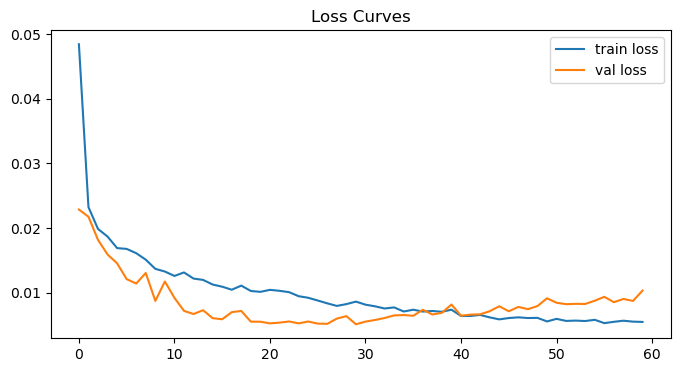

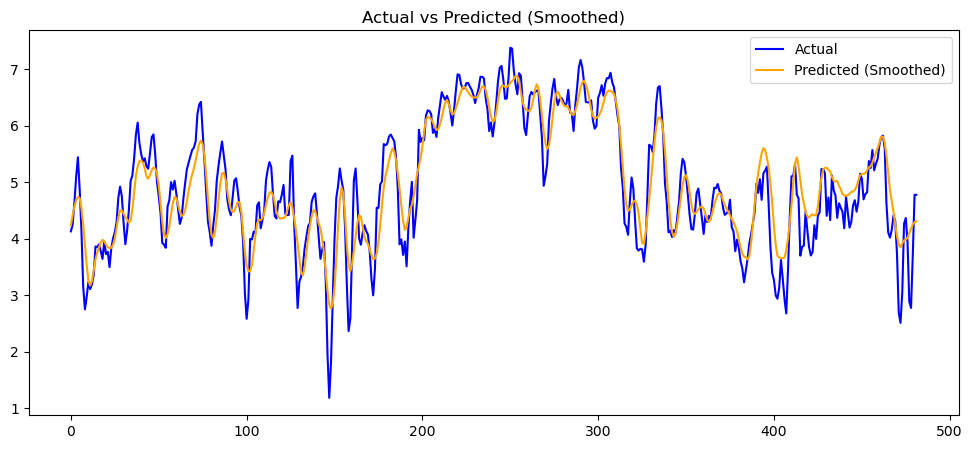

In [10]:
# -------------------------------
# 🧩 Step 10: Evaluate & Visualize
# -------------------------------
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import scipy.signal as signal

scaler_data = joblib.load("models/scaler_final.pkl")
scaler = scaler_data["scaler"]
features = scaler_data["features"]

y_pred = model.predict(X_test)
solar_idx = features.index("solar_radiation")

dummy_pred = np.zeros((len(y_pred), len(features)))
dummy_true = np.zeros((len(y_test), len(features)))
dummy_pred[:, solar_idx] = y_pred.flatten()
dummy_true[:, solar_idx] = y_test.flatten()

y_pred_inv = scaler.inverse_transform(dummy_pred)[:, solar_idx]
y_true_inv = scaler.inverse_transform(dummy_true)[:, solar_idx]

# Clip & Smooth
y_pred_inv = np.clip(y_pred_inv, 0, None)
y_pred_smooth = signal.savgol_filter(y_pred_inv, 11, 3)

r2 = r2_score(y_true_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv) * 100

print(f"📊 R² Score: {r2:.3f}")
print(f"📉 MAPE: {mape:.2f}%")

# Loss curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss Curves")
plt.show()

# Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(y_true_inv, label="Actual", color='blue')
plt.plot(y_pred_smooth, label="Predicted (Smoothed)", color='orange')
plt.legend()
plt.title("Actual vs Predicted (Smoothed)")
plt.show()


In [11]:
# -------------------------------
# 💾 Step 11: Save Final Model
# -------------------------------
model.save("models/deepenergy_final.keras")
print("✅ Model saved at models/deepenergy_final.keras")


✅ Model saved at models/deepenergy_final.keras


In [12]:
print("Check train scaled min/max:", train_scaled.min(), train_scaled.max())
print("Check test scaled min/max:", test_scaled.min(), test_scaled.max())
print("Scaler feature order:", scaler.feature_names_in_)


NameError: name 'train_scaled' is not defined

In [19]:
from tensorflow.keras.models import load_model
import joblib

model = load_model("models/deepenergy_final.keras")
print("✅ Model loaded successfully!")

scaler_data = joblib.load("models/scaler_final.pkl")
print("✅ Scaler loaded successfully!")

print(model.summary())


✅ Model loaded successfully!
✅ Scaler loaded successfully!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 90, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 90, 256)             │         144,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 692,357 (2.64 MB)

 Trainable params: 230,785 (901.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 461,572 (1.76 MB)

None


In [21]:
import joblib
scaler_data = joblib.load("models/scaler_final.pkl")
print(scaler_data.keys())


dict_keys(['scaler', 'features'])


In [23]:
import joblib
scaler_data = joblib.load("models/scaler_final.pkl")
print(scaler_data.keys())


dict_keys(['scaler', 'features'])


In [25]:
from tensorflow.keras.models import load_model
model = load_model("models/deepenergy_best.keras")
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 90, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 90, 256)             │         144,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 692,357 (2.64 MB)

 Trainable params: 230,785 (901.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 461,572 (1.76 MB)

In [27]:
import sys
print(sys.executable)












C:\Users\LENOVO\anaconda3\envs\tf_env\python.exe


In [29]:
import sklearn, joblib, numpy
print("scikit-learn:", sklearn.__version__)
print("joblib:", joblib.__version__)
print("numpy:", numpy.__version__)


scikit-learn: 1.7.2
joblib: 1.5.2
numpy: 1.26.4


In [31]:
# ✅ Re-save scaler in the current environment (fixes KeyError)
import joblib
from sklearn.preprocessing import MinMaxScaler

features = [
    "solar_radiation", "wind_speed", "temperature",
    "humidity", "rainfall", "clearsky_index",
    "pressure", "clouds",
    "month", "dayofyear", "doy_sin", "doy_cos"
]

# Fill missing columns safely
for col in features:
    if col not in final_df.columns:
        final_df[col] = 0

# Fit the scaler on final_df (the same features you used in training)
scaler = MinMaxScaler()
scaler.fit(final_df[features])

# Save with the same structure your Streamlit app expects
joblib.dump({"scaler": scaler, "features": features}, "models/scaler_final.pkl")

print("✅ Scaler successfully re-saved using current versions:")
print("scikit-learn=1.7.2, joblib=1.5.2, numpy=1.26.4")


✅ Scaler successfully re-saved using current versions:
scikit-learn=1.7.2, joblib=1.5.2, numpy=1.26.4
